In [93]:
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

from sklearn.linear_model import LinearRegression

import numpy as np

from IPython.display import display, HTML

from sklearn.mixture import GaussianMixture

import math

from scipy import stats
import statistics

%matplotlib inline

/Users/apple/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Economic opportunity by Race

In [3]:
national_collapse = pd.read_csv('data/national_collapse.csv')
print(f"Header: {national_collapse.head()}")
print(f"Races: {set(national_collapse['kid_race'])}")
national_collapse.isnull().values.any()

Header:    par_pctile kid_race gender  n_kir        kir
0           1    White      F  34000  32.930000
1           1    White      M  36000  38.959999
2           1    Black      F  29500  33.860001
3           1    Black      M  29000  29.440001
4           1    Asian      F   4300  50.080002
Races: {'Asian', 'Black', 'AIAN', 'Hispanic', 'White'}


False

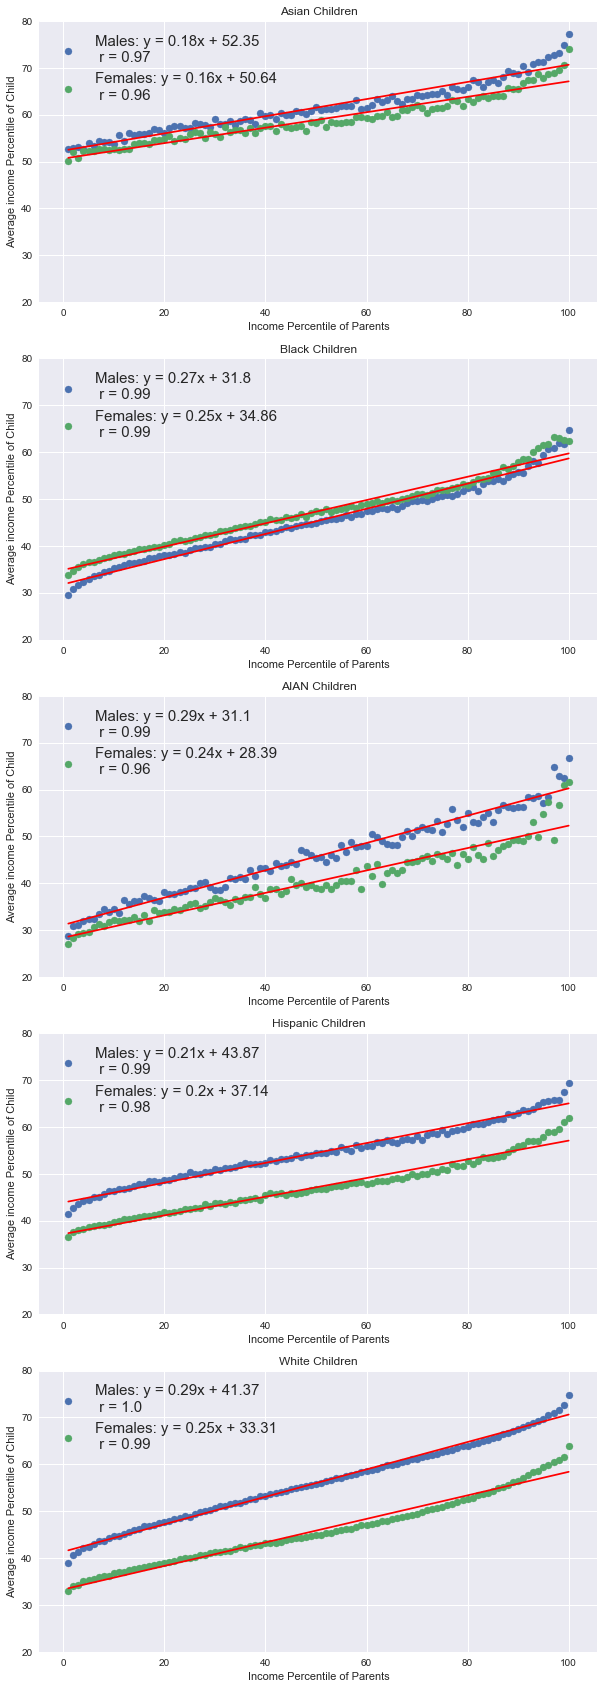

In [71]:
races = list(set(national_collapse['kid_race']))

f, axes = plt.subplots(len(races),1, figsize=(10,30))

for i, race in enumerate(races):
    males = national_collapse[(national_collapse.kid_race == race) & (national_collapse.gender == 'M')]
    females = national_collapse[(national_collapse.kid_race == race) & (national_collapse.gender == 'F')]
    
#     male_fit = np.poly1d(np.polyfit(x=males.par_pctile, y=males.kir, deg=1))
#     female_fit = np.poly1d(np.polyfit(x=females.par_pctile, y=females.kir, deg=1))
    
    male_slope, male_intercept, male_r_value, male_p_value, male_std_err = stats.linregress(males.par_pctile, males.kir)
    female_slope, female_intercept, female_r_value, female_p_value, female_std_err = stats.linregress(females.par_pctile, females.kir)
    
    axes[i].set_ylim([20,80])
    
    axes[i].scatter(males.par_pctile, males.kir, label=f'Males: y = {round(male_slope,2)}x + {round(male_intercept,2)} \n r = {round(male_r_value,2)}')
    axes[i].scatter(females.par_pctile, females.kir, label=f'Females: y = {round(female_slope, 2)}x + {round(female_intercept, 2)} \n r = {round(female_r_value, 2)}')
    axes[i].legend(prop={'size': 15})
    axes[i].set_title(race + " Children")

    axes[i].plot(males.par_pctile, males.par_pctile*male_slope + male_intercept, color='r')
    axes[i].plot(females.par_pctile, females.par_pctile*female_slope + female_intercept, color='r')
    axes[i].set(xlabel='Income Percentile of Parents', ylabel='Average income Percentile of Child')
    
    # Total mobility
#     print(f"{race} males: {sum([male_slope * i + male_intercept for i in range(100)])}")
#     print(f"{race} females: {sum([female_slope * i + female_intercept for i in range(100)])}")
        

In [72]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [115]:
table = []
for race in races:
    mapper = {'F': 0, 'M': 1}
    x = national_collapse[national_collapse['kid_race'] == race]
    x['gender'] = x['gender'].replace(mapper)
    y = x['kir']
    x = x.drop(['kid_race', 'n_kir', 'kir'], axis=1)
    
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    x_inter = interaction.fit_transform(x)

    regr = LinearRegression()
    model = regr.fit(x_inter[:,:2], y)
#     print(model.score(x_inter, y))
    coefs = np.round(model.coef_, 3)
    b = np.round(model.intercept_)
    print(race)
#     print(f"child_pctile = {b} + ({coefs[0]} * par_pctile) + ({coefs[1]} * gender) + ({coefs[2]} * gender * par_pctile)")
#     print(f"Male: {coefs[0] + coefs[2]}")
#     print(f"Female: {coefs[0]}")
#     print()
    print(coefs)
    print(b)
    
    
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
#     print(results.summary()) 
    conf_interval = results.conf_int().T['gender']
    table.append([race, coefs[1], conf_interval[0], conf_interval[1]])
    

Asian
[ 0.174  2.635]
50.0
Black
[ 0.259 -2.053]
34.0
AIAN
[ 0.265  5.365]
27.0
Hispanic
[ 0.206  7.341]
37.0
White
[  0.272  10.16 ]
32.0


/Users/apple/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [117]:
header = ['Race', 'B_2', '0.025', '0.975'] 
pd.DataFrame(table, columns=header)

,Race,B_2,0.025,0.975
0,Asian,2.635,2.259150,3.010051
1,Black,-2.053,-2.407816,-1.697384
2,AIAN,5.365,4.836682,5.892918
3,Hispanic,7.341,7.056964,7.625236
4,White,10.160,9.833018,10.487582


# Economic opportunity by Location 

In [4]:
tract_collapse = pd.read_csv('data/tract_collapse.csv')
display(tract_collapse.tail())

community_zone = pd.read_csv('data/cz_county_crosswalk.csv')
community_zone.tail()

,state,county,tract,kir_black_p25,kir_pooled_p25,kir_white_p25,kid_pooled_n,kid_white_n,kid_black_n
72362,56,43,200,NaN,49.586548,52.203770,898,720,4
72363,56,43,301,NaN,43.387756,44.873482,730,556,0
72364,56,43,302,NaN,43.716778,45.138992,630,521,0
72365,56,45,951100,NaN,45.466404,45.431171,691,652,0
72366,56,45,951300,NaN,47.255253,47.874863,907,830,4


,cz,state,county,czname
3133,39400,53,45,Seattle
3134,39400,53,53,Seattle
3135,39400,53,57,Seattle
3136,39400,53,61,Seattle
3137,39400,53,67,Seattle


In [5]:
zones = list(set(community_zone['czname']))
zone_mobility = {'zone': [], 'mobility': [], 'kid_pooled_n': [], 'kid_white_n': [], 'kid_black_n': []}

for zone in zones:
    location_codes = community_zone[community_zone.czname == zone]
    
    zone_data = []
    
    for index, code in location_codes.iterrows():
        tract_data = tract_collapse[(tract_collapse.state == code.state) & (tract_collapse.county == code.county)]
        zone_data.append(tract_data)
    
    zone_data = pd.concat(zone_data)
    zone_data.dropna()
    
    weighted_average = (zone_data['kir_pooled_p25'] * zone_data['kid_pooled_n']).sum() / zone_data['kid_pooled_n'].sum()
    zone_mobility['zone'].append(zone)
    zone_mobility['mobility'].append(weighted_average)

    zone_mobility['kid_pooled_n'].append(sum(zone_data['kid_pooled_n']))
    zone_mobility['kid_white_n'].append(sum(zone_data['kid_white_n']))
    zone_mobility['kid_black_n'].append(sum(zone_data['kid_black_n']))
        
zone_mobility = pd.DataFrame(zone_mobility)

In [6]:
national_average = zone_mobility['mobility'].mean()
print(national_average)
zone_mobility['mobility'] = zone_mobility['mobility'] - national_average


zone_mobility = zone_mobility.sort_values(by='mobility')
top_bottom_five = pd.concat([zone_mobility[-5:], zone_mobility[:5]])
top_bottom_five = top_bottom_five.sort_values(by='mobility')[::-1]

44.096929617995364


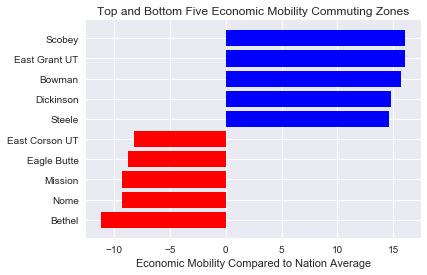

In [7]:
fig, ax = plt.subplots()

coloring = ['blue'] * 5 + ['red'] * 5

y_pos = np.arange(len(top_bottom_five))
ax.barh(y_pos, top_bottom_five['mobility'], align='center',
        color=coloring, ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_bottom_five['zone'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Economic Mobility Compared to Nation Average')
ax.set_title('Top and Bottom Five Economic Mobility Commuting Zones')

In [8]:
kids_pooled_n = [] 
kids_white_n = []
kids_black_n = []


display(top_bottom_five)

national_pop_median = zone_mobility['kid_pooled_n'].median()
top_five_pop_median = top_bottom_five['kid_pooled_n'][:5].median()
bottom_five_pop_median = top_bottom_five['kid_pooled_n'][-5:].median()

national_white_pct = (zone_mobility['kid_white_n'] / zone_mobility['kid_pooled_n']).mean()
national_black_pct = (zone_mobility['kid_black_n'] / zone_mobility['kid_pooled_n']).mean()

top_white_pct = (top_bottom_five['kid_white_n'][:5] / top_bottom_five['kid_pooled_n'][:5]).mean()
bottom_white_pct = (top_bottom_five['kid_white_n'][-5:] / top_bottom_five['kid_pooled_n'][-5:]).mean()

top_black_pct = (top_bottom_five['kid_black_n'][:5] / top_bottom_five['kid_pooled_n'][:5]).mean()
bottom_black_pct = (top_bottom_five['kid_black_n'][-5:] / top_bottom_five['kid_pooled_n'][-5:]).mean()



print(f"National Median of Community Zone Child Population: {national_pop_median}")
print(f"Top Five Median of Community Zone Child Population: {top_five_pop_median}")
print(f"Bottom Five Median of Community Zone Child Population: {bottom_five_pop_median}\n")

print(f"National average of Percentage of community zone child population that is white: {national_white_pct}")

print(f"Top Five average of Percentage of community zone child population that is white: {top_white_pct}")
print(f"Bottom Five average of Percentage of community zone child population that is white: {bottom_white_pct}\n")

print(f"Nationa`l average of Percentage of community zone child population that is black: {national_black_pct}")
print(f"Top Five average of Percentage of community zone child population that is black: {top_black_pct}")
print(f"Bottom Five average of Percentage of community zone child population that is black: {bottom_black_pct}\n")

,kid_black_n,kid_pooled_n,kid_white_n,mobility,zone
633,0,446,400,16.088632,Scobey
80,0,666,606,16.027162,East Grant UT
525,0,974,952,15.719160,Bowman
250,19,6988,6495,14.826469,Dickinson
422,4,638,625,14.670137,Steele
444,2,3174,477,-8.217564,East Corson UT
91,0,3347,472,-8.801500,Eagle Butte
683,1,4713,456,-9.301057,Mission
202,7,3416,358,-9.356111,Nome
188,21,6377,376,-11.208971,Bethel


National Median of Community Zone Child Population: 27043.0
Top Five Median of Community Zone Child Population: 666.0
Bottom Five Median of Community Zone Child Population: 3416.0

National average of Percentage of community zone child population that is white: 0.7314460317478435
Top Five average of Percentage of community zone child population that is white: 0.9386515876925868
Bottom Five average of Percentage of community zone child population that is white: 0.11036437112336106

Nationa`l average of Percentage of community zone child population that is black: 0.0910245166084827
Top Five average of Percentage of community zone child population that is black: 0.0017977078484746802
Bottom Five average of Percentage of community zone child population that is black: 0.001236912730452343



## Median Income and Mobility

In [9]:
tract_covariates = pd.read_csv('data/tract_covariates.csv')
display(tract_covariates.tail())

assert (tract_covariates['tract'] == tract_collapse['tract']).all()

,tract,county,state,hhinc_mean2000
72362,200,43,56,64601.723
72363,301,43,56,60204.770
72364,302,43,56,71637.672
72365,951100,45,56,66917.867
72366,951300,45,56,55282.840


white Children stats: 
r-value: 0.4764059110999809
p-value: 0.0

black Children stats: 
r-value: 0.33707072549952516
p-value: 0.0

pooled Children stats: 
r-value: 0.5563281159359406
p-value: 0.0



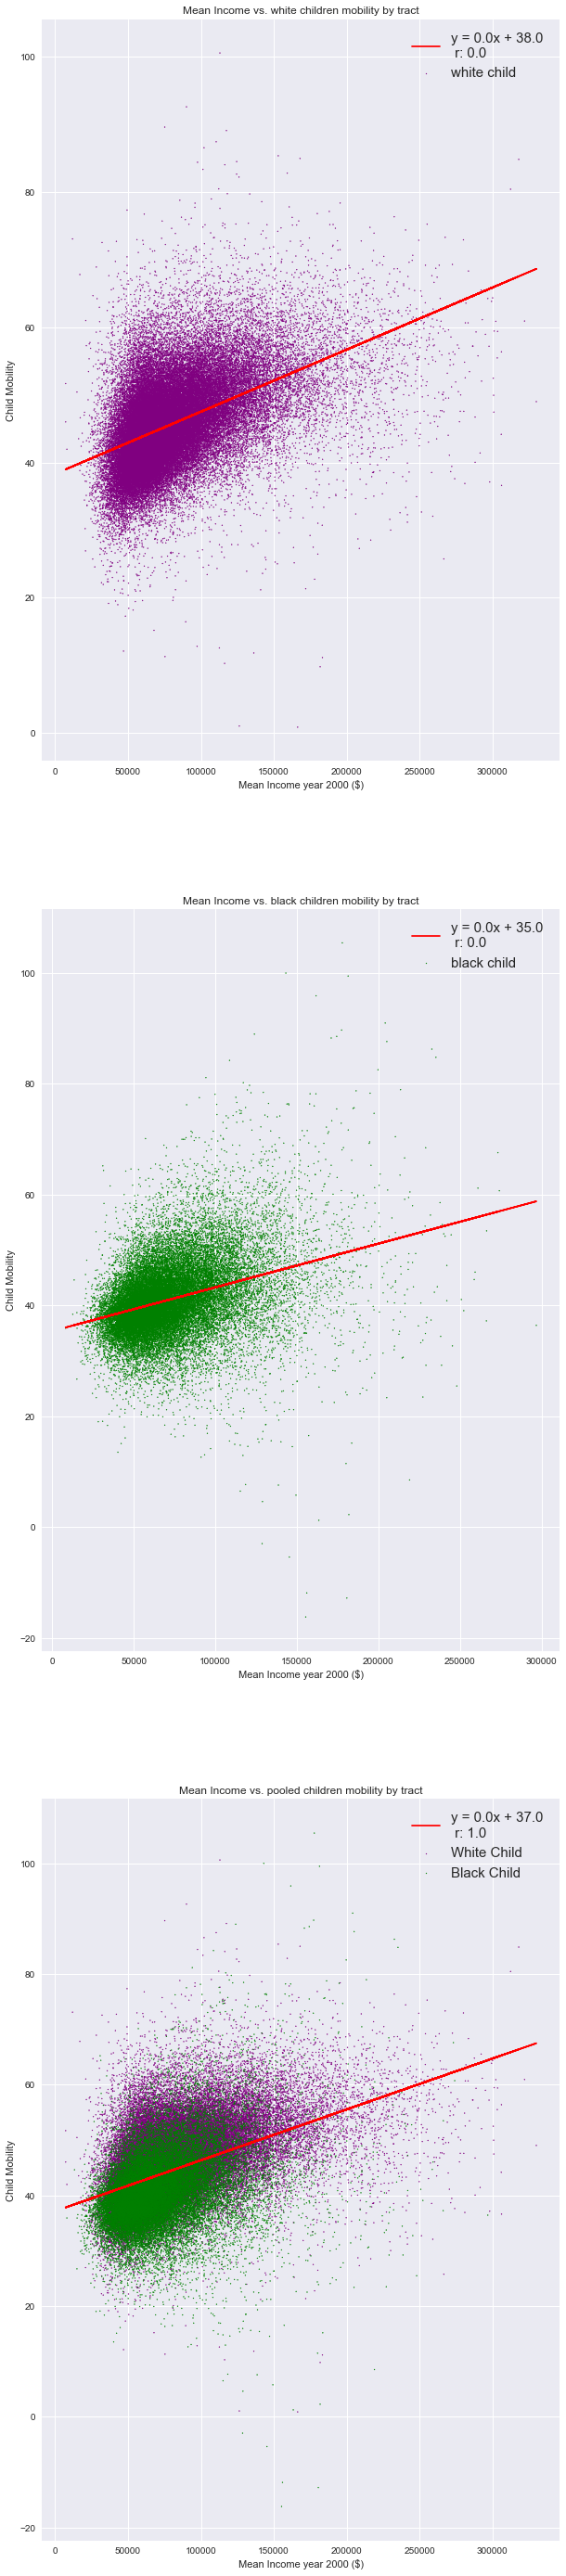

In [10]:
races = ['white', 'black', 'pooled']
colors = {'white':'purple', 'black':'g'}
f, axes = plt.subplots(len(races),1, figsize=(10,50))

for i, race in enumerate(races):
    if race == 'pooled':
        axes[i].scatter(tract_covariates['hhinc_mean2000'], tract_collapse["kir_white_p25"], s=[1]*len(tract_covariates), c=colors['white'], label='White Child')
        axes[i].scatter(tract_covariates['hhinc_mean2000'], tract_collapse["kir_black_p25"], s=[1]*len(tract_covariates), c=colors['black'], label='Black Child')
        
    else:
        axes[i].scatter(tract_covariates['hhinc_mean2000'], tract_collapse[f"kir_{race}_p25"], s=[1]*len(tract_covariates), c=colors[race], label=f"{race} child")
    
    axes[i].set_title(f"Mean Income vs. {race} children mobility by tract")
    axes[i].set(xlabel='Mean Income year 2000 ($)', ylabel='Child Mobility') 
    
    data = pd.concat([tract_covariates['hhinc_mean2000'], tract_collapse[f"kir_{race}_p25"]], axis=1)
    data = data.dropna()
    
    y = data[f"kir_{race}_p25"]
    x = data['hhinc_mean2000']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    axes[i].plot(x, x*slope + intercept, color='r', label=f"y = {round(slope)}x + {round(intercept)} \n r: {round(r_value)}")
    axes[i].legend(prop={'size': 15})
    
    cov_matrix = np.cov(data.T)
    correlation = (cov_matrix[0][1] / math.sqrt(cov_matrix[0][0] * cov_matrix[1][1]))
#     print(f"Np.cov correlation: {correlation}")
    print(f"{race} Children stats: ")
    print(f"r-value: {r_value}")
    print(f"p-value: {p_value}\n")
#     print(f"std_err: {std_err}")